# Tutorial 5 - Activity Recognition

Make sure that you review the video introduction for this tutorial. Otherwise it will not make sense!

In this tutorial we are going to reviewing a complete workflow that ties together data colection, data annotation and training of a machine learning algorithm on a small dataset collected using an Inertial Measurement Unit(IMU). The IMU used to create the dataset is the SparkFun 9DoF Razor IMU: https://www.sparkfun.com/products/14001 

This device has been programmed to store the readings from the on-board accelerometer and gyroscope to a file on the SD card at (approximately) 250 samples per second. A video of the data collection was recorded and used to create an *annotation* dataset that contains time-stamped annotations of activities.

The first part of this demonstration involves importing the IMU data and aligning it with the video and annotation data. This is done by inspecting the dataset to look for *sentinel* sections or known *datum* points between both sets. In this example, we will be using the standing points to synchonize the datasets. 

We will start by setting things up for the data import.


In [1]:
# Import all of the 
import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_confusion_matrix
import dtreeviz

# Set some lists to store the IMU data.

time_track = []
ax_set = []
ay_set = []
az_set = []

gx_set = []
gy_set = []
gz_set = []

activity_set = []

#####################################################
# map_activity(activity_string)
#
# A simple function that maps the activity description
# string from the VoTT data file to a integer value
# that will be used by the machine learning workflow.
#
#####################################################

def map_activity(activity_string):
    if activity_string == 'Standing':
        return 0
    elif activity_string == 'Walking':
        return 1
    elif activity_string == 'Jogging':
        return 2
    elif activity_string == 'Side_step':
        return 3
    elif activity_string == 'Running':
        return 4
    elif activity_string == 'High_knees':
        return 5



Now we can import the data file colelcted from the IMU. We will store the data in a set of lists for later use.

In [2]:
with open('outfile.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        #print(row)
        time_track.append(float(row[0]));
        ax_set.append(float(row[1]));
        ay_set.append(float(row[2]));
        az_set.append(float(row[3]));
        gx_set.append(float(row[4]));
        gy_set.append(float(row[5]));
        gz_set.append(float(row[6]));

The first thing we will do is visualise the data to sanity check what we have imported

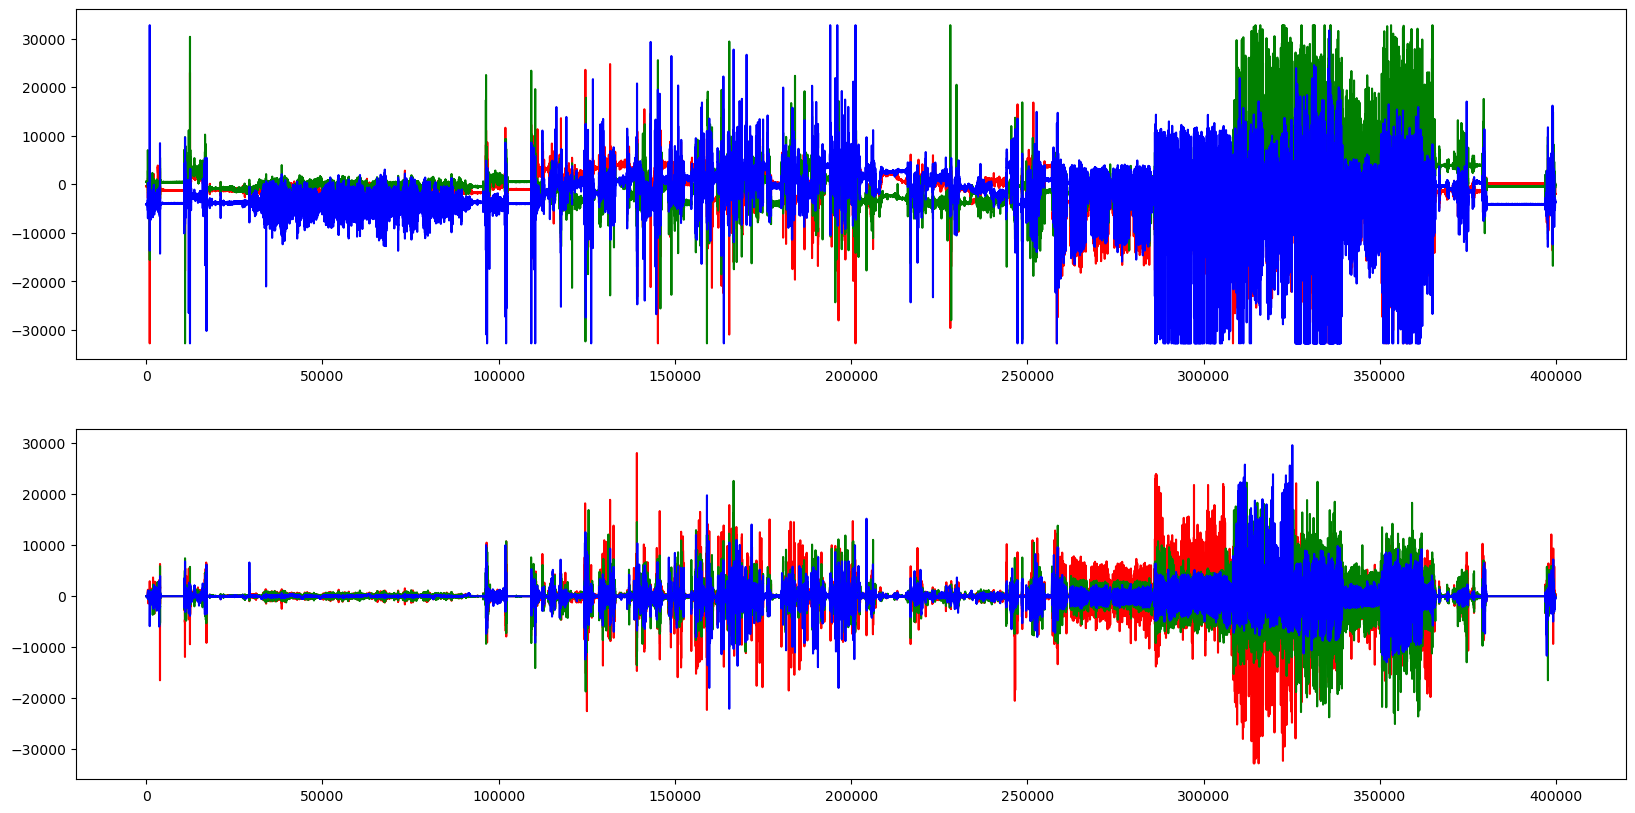

In [3]:
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')

By inspection, we can see that the data we are after is @ approx. position 250000-360000. By experimentation and a review of the accompanying video, we can observe that the data we are after starts at index 262000. This closly corresponds with the start of the video

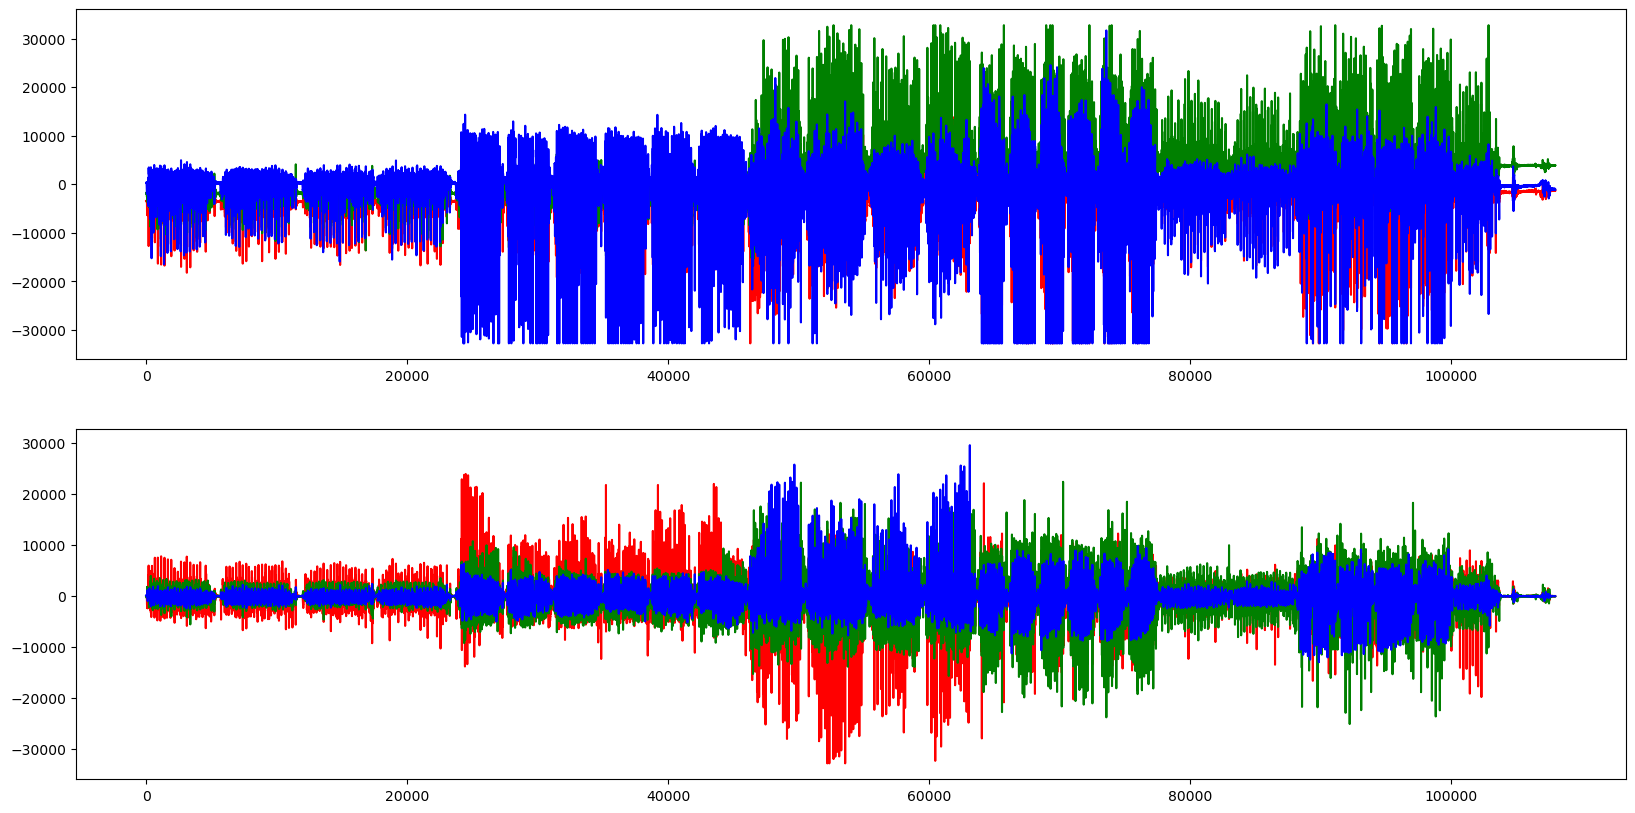

In [4]:
start_idx = 262000

fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set[start_idx:370000], color='r')
axs[0].plot(ay_set[start_idx:370000], color='g')
axs[0].plot(az_set[start_idx:370000], color='b')

axs[1].plot(gx_set[start_idx:370000], color='r')
axs[1].plot(gy_set[start_idx:370000], color='g')
axs[1].plot(gz_set[start_idx:370000], color='b')

We have the start point. Now we need to find the end point in the data. This is conveniently given by the length of the data collection video (443 seconds). This video has been 'cut' using editing software so that the start and end of the video matches the start and end of the activities. 

1597104114.0


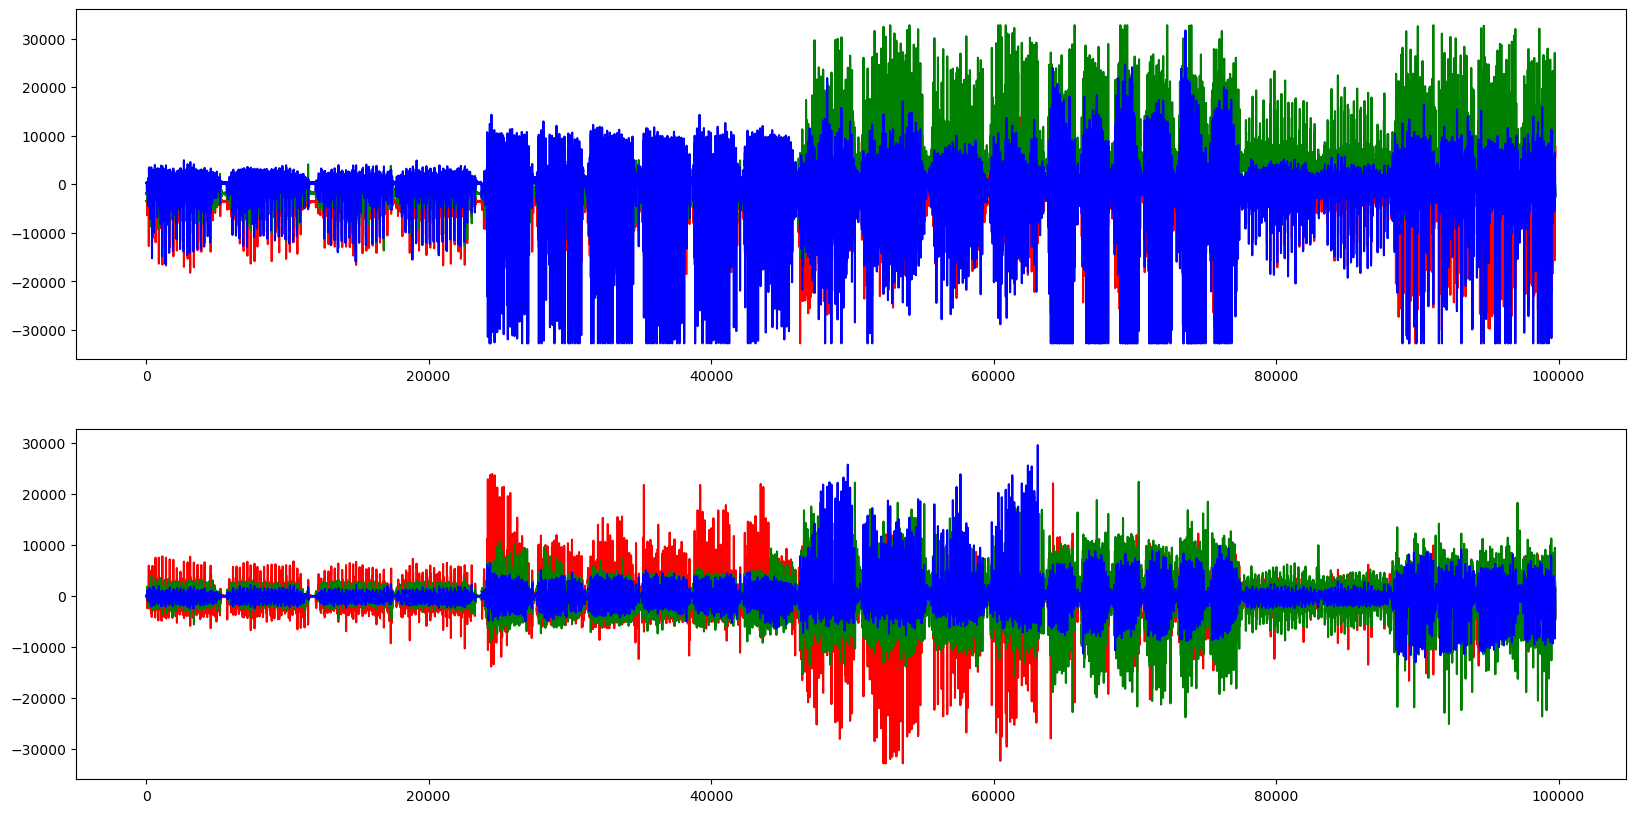

In [5]:
#Now we need to find the end point
start_ts = time_track[start_idx];
print(start_ts)

# The video has been cut to 443 seconds in length - need to find 
# Start_ts + 443 seconds. This should land us at the end point
# We can sanity check this by inspecting the plot

end_idx = time_track.index(start_ts+443)

# Sanity Check
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set[start_idx:end_idx], color='r')
axs[0].plot(ay_set[start_idx:end_idx], color='g')
axs[0].plot(az_set[start_idx:end_idx], color='b')

axs[1].plot(gx_set[start_idx:end_idx], color='r')
axs[1].plot(gy_set[start_idx:end_idx], color='g')
axs[1].plot(gz_set[start_idx:end_idx], color='b')


## The Activity Annotations

Now we can turn our attention to the activity track that we have created using VoTT. First we need to read in the activity annotation file that we made in VoTT.

In [6]:
with open('imu_data-export.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader, None)  # skip the headers
    for row in reader:
        time_Stamp = (row[0].split('='))[1]
        activity_set.append([float(time_Stamp),row[-1], map_activity(row[-1])])

Now that we have the activity annotations from the VoTT file, the first task is to assign every data reading within the IMU dataset a corresponding activity. The annoations file simply lists the start time for each activity - we needed to use these time listings to assign an activity to each data point using the timestamp within the IMU dataset.

You can download and explort VoTT from the website: https://github.com/microsoft/VoTT

We will achieve this by looping through the IMU data and assigning the corresponding activity from the activity annotation file. We start at the first activity annoation and the first IMU data point.

We will also plot the annotation points (as vertical lines) to sanity check the activity transitions and see if they correspond to changes in the underlying data.

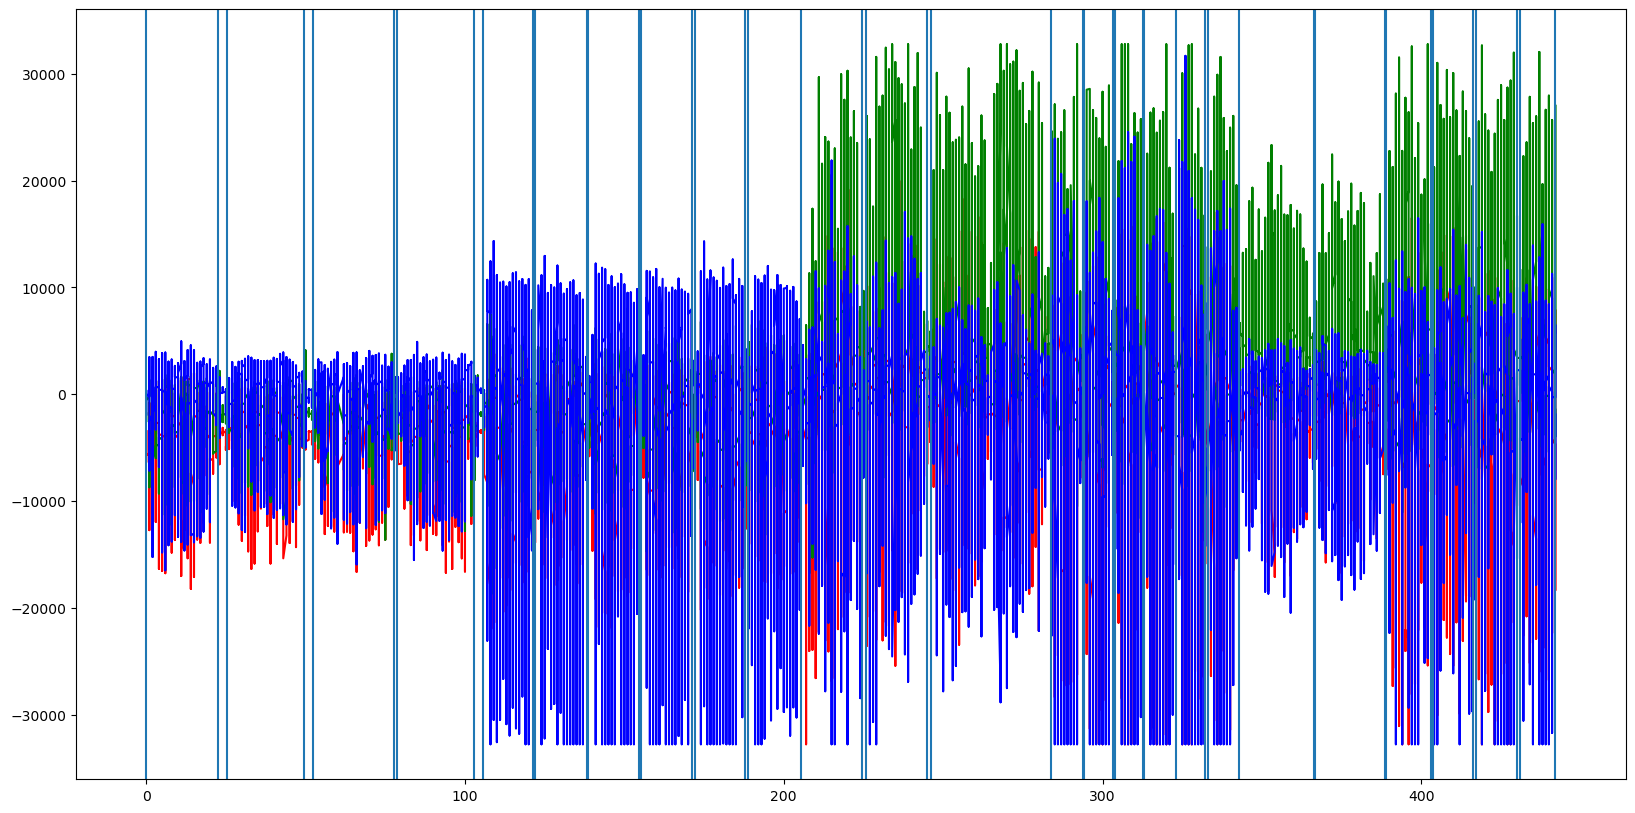

In [7]:
# Now we can create an activity time track for each data point within
# the imu timeseries. We will have a list to store the numeric code and the string.
activity_timeseries = [];
activity_string_timeseries = [];
activity_idx = 0;

# We need the time stamp for the start point
start_time = time_track[start_idx]

# The time track segment we are interested in 
time_track_segment = time_track[start_idx:end_idx]

#Add an 'end' activity - this book-ends the data
activity_set.append([time_track_segment[-1]-start_time, 'Standing'])

# Zero out the time track segment to make it match the video time
time_track_segment = np.array(time_track_segment)-start_time

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_track_segment,ax_set[start_idx:end_idx], color='r')
ax.plot(time_track_segment,ay_set[start_idx:end_idx], color='g')
ax.plot(time_track_segment,az_set[start_idx:end_idx], color='b')


for imu_time_track_item in time_track_segment:
    current_time =  imu_time_track_item
    next_activity_ts = activity_set[activity_idx+1][0]
    
    # Here we need to move to the next activity in the annotations data if the current
    # IMU data point lies after the next annotation time stamp.
    if current_time > next_activity_ts:
        #Move to nex activity
        activity_idx = activity_idx + 1;
        next_activity_ts = activity_set[activity_idx+1][0]
    
    
    activity_timeseries.append(activity_set[activity_idx][2])
    activity_string_timeseries.append(activity_set[activity_idx][1])

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act))

It would be good to understand the balance of the data classes (i.e. the number of data points for each activity). This will inform us around the expected performance in a classifier algorithm. We will plot a histgram using the numeric activity code data. 

(array([ 6214., 32682., 21709., 17219., 10738., 11208.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

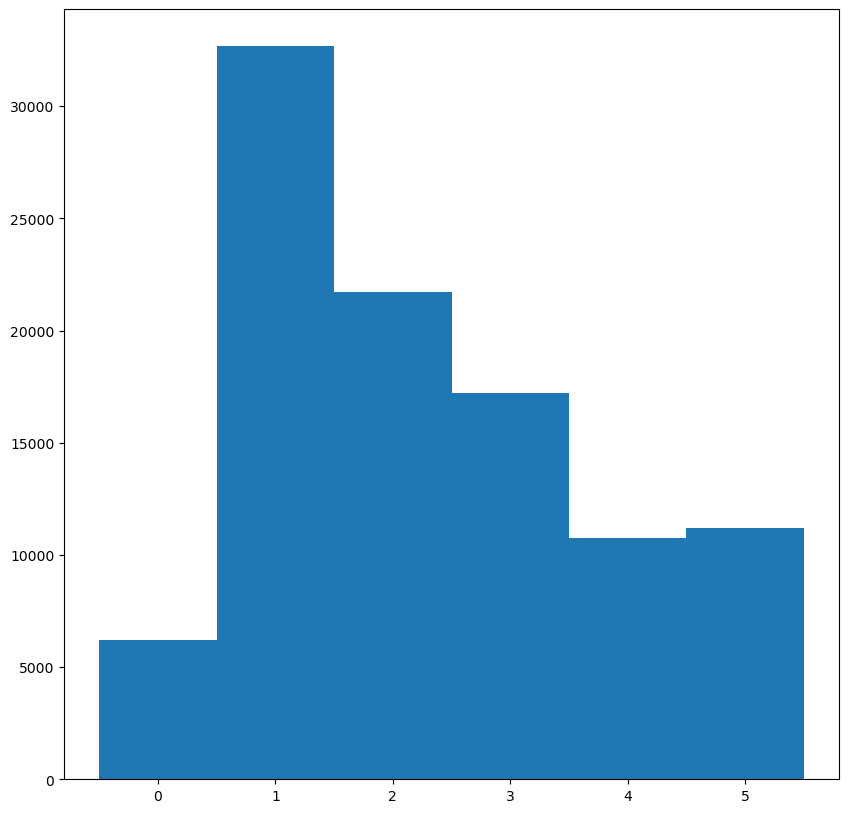

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(activity_timeseries,bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5])

In [9]:
#We are only interested in the video window
ax_set = ax_set[start_idx:end_idx]
ay_set = ay_set[start_idx:end_idx]
az_set = az_set[start_idx:end_idx]
gx_set = gx_set[start_idx:end_idx]
gy_set = gy_set[start_idx:end_idx]
gz_set = gz_set[start_idx:end_idx]

## Machine Learning Features

Now we have a combined dataset, we can start looking at applying a machine learning workflow. The first part of this process will involve computing some features for the dataset. 

To make our data generalize, we are interesting in look at at *windows* of data - small segments that correspond to specific time periods within the data. This is called the 'moving' window approach and it essentially involves taking fixed-length segments of data and calculating *features* across these segments. We will compute features across the accelerometer and gyroscope datasets.

The features we will calculate are:
* Mean (x, y and z axes)
* Minimum (x, y and z axes)
* Maximum (x, y and z axes)
* The Signal Magnitude Area: $ SMA = \frac{1}{T} (\sum _{t=1}^{T} |{a_x(t)}| + \sum _{t=1}^{T} |{a_y(t)}| + (\sum _{t=1}^{T} |{a_z(t)}|)$

* Average intensity $ AI = \frac{1}{T} (\sum _{t=1}^{T} (\sqrt{a_x(t)^2 + a_y(t)^2 + a_y(t)^2})$

These features are based upon experiments and literature and have proven effective for activity classification across a range of applications.

Will will use a **window size of 1 second**. This is a parameter that we can adjust and experiment with, however in previous experiments on human acticity, a 1 second window has been very effective. 

This code takes a few seconds to run - there are a lot of calculations!


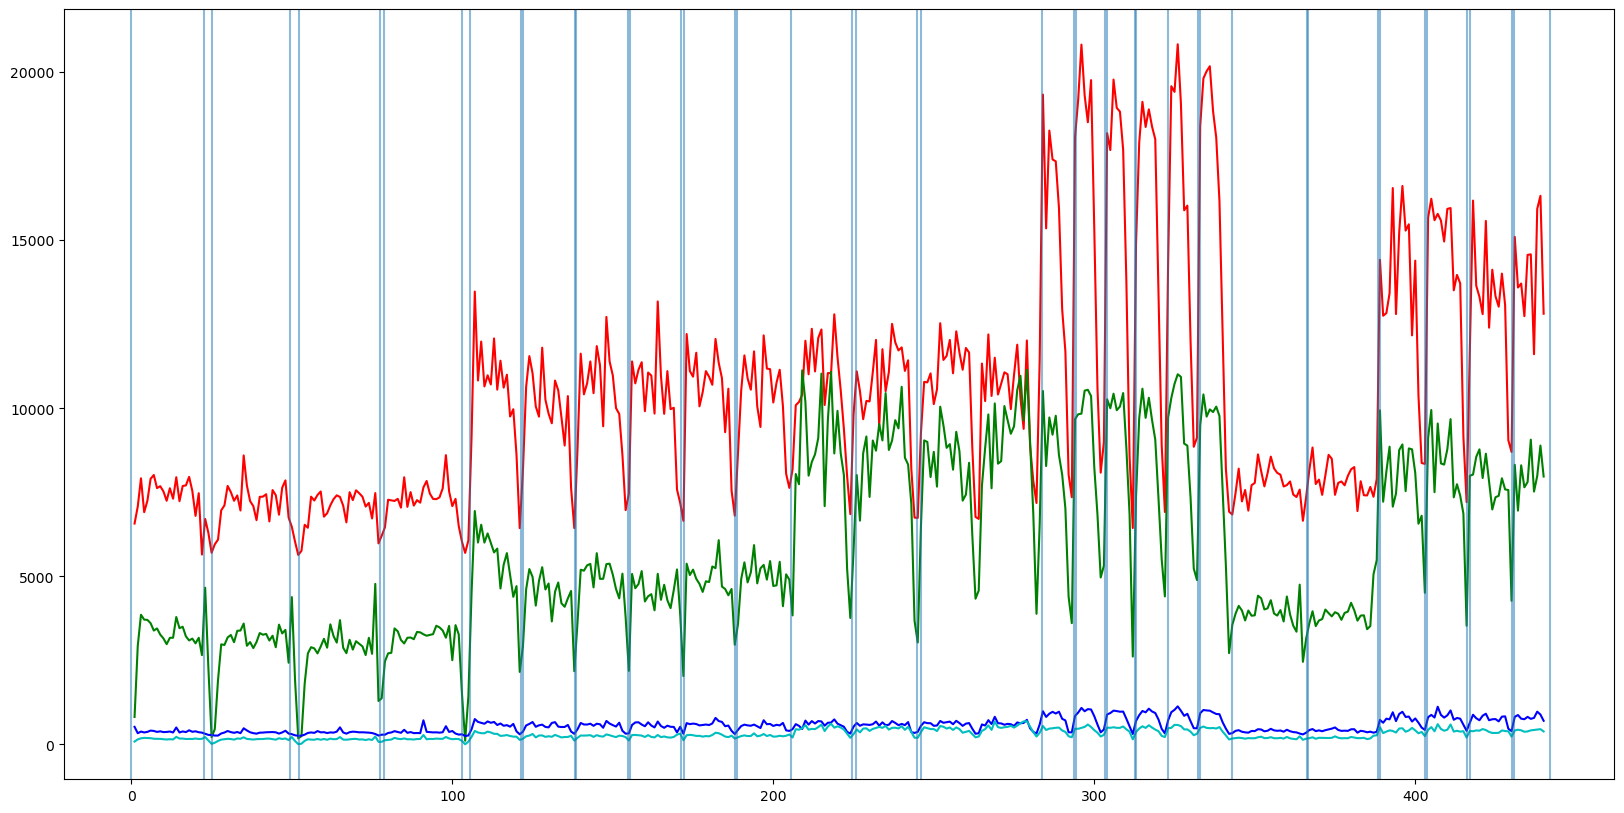

In [10]:
# Now we can start working on the machine learning workflow.
# The first step is to calculate some feature that we can use.
# We will base our analysis around a moving window across the
# the timeseries data. This involves taking a fixed length window, based upon the time, and
# sliding it across the data.
# To keep thing simple, we will start with a 1 second window with no overlapping
# data points

feature_set = []
target_set  = []            
window_size = 1.0;            

for t in range(int(time_track_segment[0]),int(time_track_segment[-1])):
    
    #There is a missing data-point (probably due to a bad segment on the SD card)
    if t == 60 or t == 61 :
        continue
    
    #The index function finds the index of the first occurnace of the data
    window_start_idx = list(time_track_segment).index(t)
    window_end_idx = list(time_track_segment).index(t+window_size)
    ax_window = ax_set[window_start_idx:window_end_idx]
    ay_window = ay_set[window_start_idx:window_end_idx]
    az_window = az_set[window_start_idx:window_end_idx]
    gx_window = gx_set[window_start_idx:window_end_idx]
    gy_window = gy_set[window_start_idx:window_end_idx]
    gz_window = gz_set[window_start_idx:window_end_idx]

    #activity that will be assigned to the set of features
    activity_code = activity_timeseries[window_start_idx]

    # Now we can build features from the data window
    # Mean
    mu_ax = statistics.mean(ax_window)
    mu_ay = statistics.mean(ay_window)
    mu_az = statistics.mean(az_window)
    mu_gx = statistics.mean(gx_window)
    mu_gy = statistics.mean(gy_window)
    mu_gz = statistics.mean(gz_window)
    
    # Max
    max_ax = max(ax_window)
    max_ay = max(ay_window)
    max_az = max(az_window)
    max_gx = max(gx_window)
    max_gy = max(gy_window)
    max_gz = max(gz_window)
    
    # Min
    min_ax = min(ax_window)
    min_ay = min(ay_window)
    min_az = min(az_window)
    min_gx = min(gx_window)
    min_gy = min(gy_window)
    min_gz = min(gz_window)
    
    ax_abs_sum = 0
    ay_abs_sum = 0
    az_abs_sum = 0
    
    gx_abs_sum = 0
    gy_abs_sum = 0
    gz_abs_sum = 0
    
    a_sum_sq = 0
    g_sum_sq = 0
    
    # Here we need to accumulate the values to calculate the SMA and AI
    for i in range(0, len(ax_window)):
        
        # Add up the absolute values for the SMA
        ax_abs_sum = ax_abs_sum + abs(ax_window[i])
        ay_abs_sum = ay_abs_sum + abs(ay_window[i])
        az_abs_sum = az_abs_sum + abs(az_window[i])
        
        gx_abs_sum = gx_abs_sum + abs(gx_window[i])
        gy_abs_sum = gy_abs_sum + abs(gy_window[i])
        gz_abs_sum = gz_abs_sum + abs(gz_window[i])
        
        
        a_sum_sq = ((ax_window[i]**2) + (ay_window[i]**2) + (az_window[i]**2)) + a_sum_sq
        g_sum_sq = ((gx_window[i]**2) + (gy_window[i]**2) + (gz_window[i]**2)) + g_sum_sq
    
    # Signal Magnitude area    
    a_sma = (ax_abs_sum + ay_abs_sum + az_abs_sum) / len(ax_window)
    g_sma = (gx_abs_sum + gy_abs_sum + gz_abs_sum) / len(ax_window)

    # Average intensity
    a_av_intensity = math.sqrt(a_sum_sq) / len(ax_window)
    g_av_intensity = math.sqrt(g_sum_sq) / len(ax_window)


    feature_row = [mu_ax, mu_ay, mu_az, mu_gx, mu_gy, mu_gz, \
                   max_ax, max_ay, max_az, max_gx, max_gy, max_gz, \
                   min_ax, min_ay, min_az, min_gx, min_gy, min_gz, \
                   a_sma, g_sma, a_av_intensity, g_av_intensity]

    feature_set.append(feature_row)
    target_set.append(activity_code)

# Lets visualise some of the features just out of interest - we will look at the SMA and AI

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(1,441),np.array(feature_set)[:,18], color='r')
ax.plot(range(1,441),np.array(feature_set)[:,19], color='g')
ax.plot(range(1,441),np.array(feature_set)[:,20], color='b')
ax.plot(range(1,441),np.array(feature_set)[:,21], color='c')

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act), alpha=0.5)
    

## Applying a Machine Learning Classifier

Now we have a dataset with features and targets. We can apply a machine leanring algorithm. We will train a decision tree algorithms using our usually workflow.

CV Train Recall: [0.23076923 0.88888889 0.87323944 0.80769231 0.65714286 0.81578947]
CV Train Precision: [0.4        0.82758621 0.91176471 0.97674419 0.62162162 0.60784314]
CV Train F1 Score: [0.29268293 0.85714286 0.89208633 0.88421053 0.63888889 0.69662921]
Test Recall: [0.25       0.97058824 0.91666667 0.56521739 0.7        0.81818182]
Test Precision: [0.4        0.86842105 0.84615385 1.         0.46666667 0.69230769]
Test F1 Score: [0.30769231 0.91666667 0.88       0.72222222 0.56       0.75      ]


/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


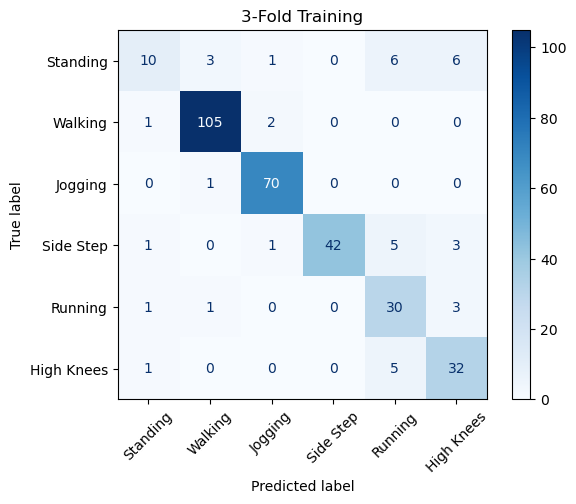

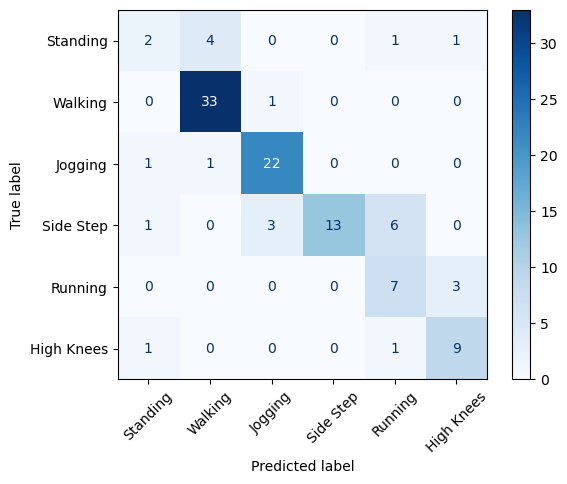

In [11]:
from sklearn import neighbors
# Now we can apply a classifier - we will use a simple Decision Tree classifier for this demo.            
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set)
# Set the number neightbours to use in the classifier
#n_neighbors = 10
# we create an instance of Neighbours Classifier and fit the data.
#clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')

# Train
clf = DecisionTreeClassifier(max_depth=4)

clf.fit(X_train, y_train)
# Return the predictions for the 3-Fold crossvalidation
y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
# Return the predictions for the test set
y_test_predicted = clf.predict(X_test)
# Construct the confusion matricies
conf_mat_train = confusion_matrix(y_train, y_predicted)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# Print out the recall, precision and F1 scores
# There will be a value for each class
# CV Train
print("CV Train Recall:", recall_score(y_train,y_predicted,average=None))
print("CV Train Precision:",precision_score(y_train,y_predicted,average=None))
print("CV Train F1 Score:",f1_score(y_train,y_predicted,average=None))

# Test
print("Test Recall:",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:",f1_score(y_test,y_test_predicted,average=None))

# Plot the confusion matrices using the pretty functions
fig, ax = plt.subplots()
disp = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running','High Knees'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('3-Fold Training')

fig, ax = plt.subplots()
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running','High Knees'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


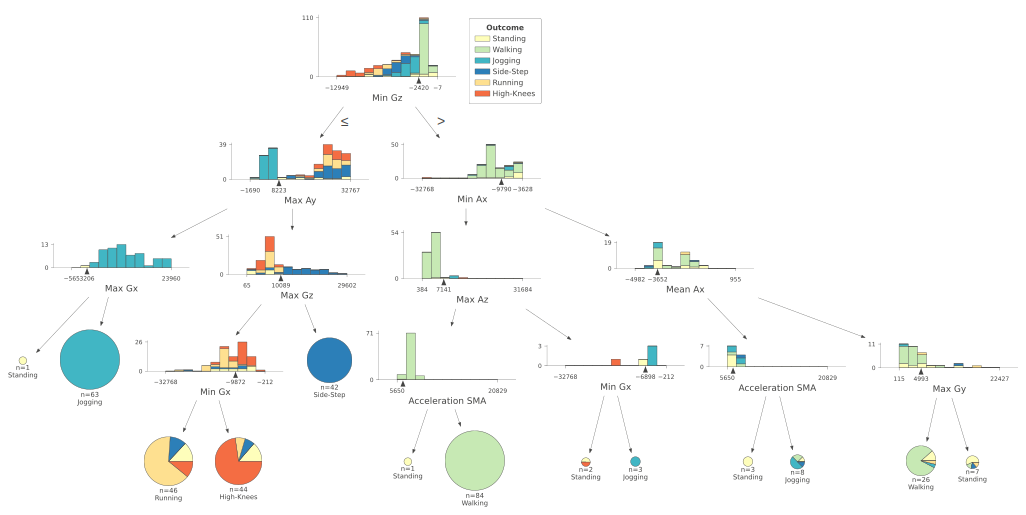

In [12]:
# Class names - I used a dictionary structure because the dtreeviz module was playing up with a list
c_names = {0:"Standing", 1:"Walking", 2:"Jogging", 3:"Side-Step", 4:"Running", 5:"High-Knees"}
# Feature names for the tree.
f_names = ["Mean Ax", "Mean Ay", "Mean Az","Mean Gx", "Mean Gy", "Mean Gz",
           "Max Ax", "Max Ay", "Max Az","Max Gx", "Max Gy", "Max Gz", 
           "Min Ax", "Min Ay", "Min Az","Min Gx", "Min Gy", "Min Gz",
           "Acceleration SMA", "Gyroscope SMA" , "Acceleration AI", "Gyroscope AI"]

# Visualise the best classifier using dtreeviz
viz = dtreeviz.model(clf, 
     np.array(X_train), 
     np.array(y_train),
     target_name ='Outcome',
     feature_names = f_names,
     class_names = c_names
    )  
              
viz.view() 

## Exercises for You

This tutorial is primerily a demonstration of the *data collection-to-machine leaning* workflow, however there a  few simple tasks to help you explore the code.

1. Modify the code above and explore the impact of changing the `max_depth` of the decision tree.
2. From observation of the tree visualisation, which features appear to be the most important for the classifiction?
3. What issues can you identify with the dataset and how are these expressed in the results?
4. Modify the code to train a KNN neighbours classifier and assess its performance (explore the N hyperparameter and see what effect it has on the classification).



CV Train Recall: [0.03846154 0.99074074 0.90140845 0.82692308 0.8        0.81578947]
CV Train Precision: [0.25       0.75352113 0.98461538 0.93478261 0.71794872 0.91176471]
CV Train F1 Score: [0.06666667 0.856      0.94117647 0.87755102 0.75675676 0.86111111]
Test Recall: [0.         1.         0.83333333 0.73913043 0.6        0.90909091]
Test Precision: [0.         0.69387755 1.         1.         0.85714286 0.76923077]
Test F1 Score: [0.         0.81927711 0.90909091 0.85       0.70588235 0.83333333]


/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


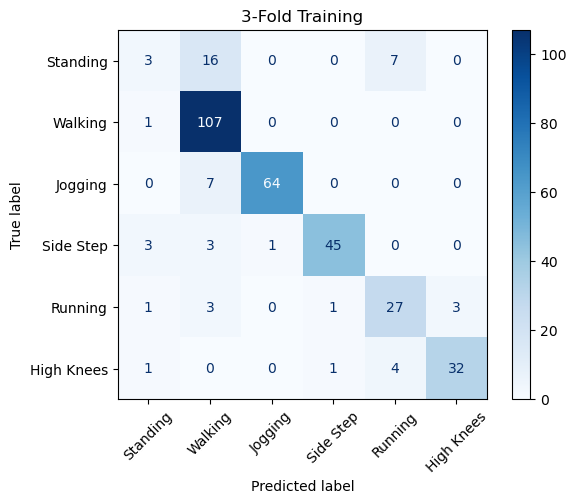

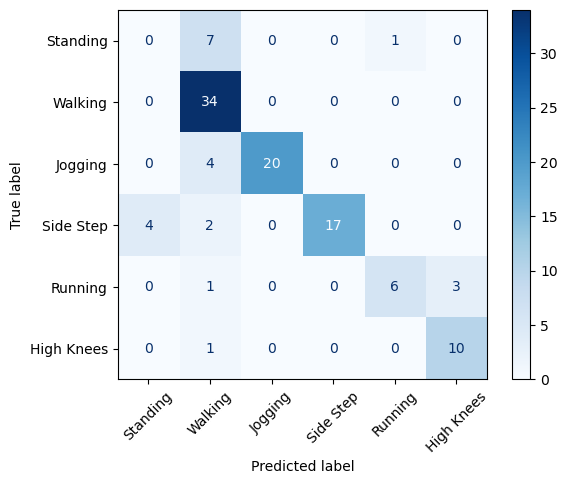

In [13]:
n_neighbors = 10

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X_train, y_train)

y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
y_test_predicted = clf.predict(X_test)
conf_mat_train = confusion_matrix(y_train, y_predicted)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

print("CV Train Recall:", recall_score(y_train,y_predicted,average=None))
print("CV Train Precision:",precision_score(y_train,y_predicted,average=None))
print("CV Train F1 Score:",f1_score(y_train,y_predicted,average=None))

print("Test Recall:",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:",f1_score(y_test,y_test_predicted,average=None))

fig, ax = plt.subplots()
disp = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running','High Knees'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('3-Fold Training')

fig, ax = plt.subplots()
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running','High Knees'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)